## Hierarchical Agent Teams


이전에 소개한 Multi-Agent 예제에서는 단일 supervisor agent가 여러 작업자 agent와 소통하며 작업을 조정하는 시스템을 살펴봤습니다.

하지만 단일 작업자 agent가 다루는 작업이 너무 많아지거나 작업자 agent가 너무 많아진다면 단순한 supervisor multi-agent 시스템 만으로는 한계가 있습니다.

이러한 상황에선 계층적으로 단계를 좀더 나눠서 작업을 분배하는 시스템을 만들면 더 효과적으로 작동할 수 있습니다.

이번 실습에서는 이를 위해 서브그래프(Subgraph)를 구성하고, 최상위 감독자(Top-Level Supervisor)와 중간 감독자(Mid-Level Supervisors)를 추가하여 **리서치 어시스턴트(Research Assistant)**를 만들어 보겠습니다!

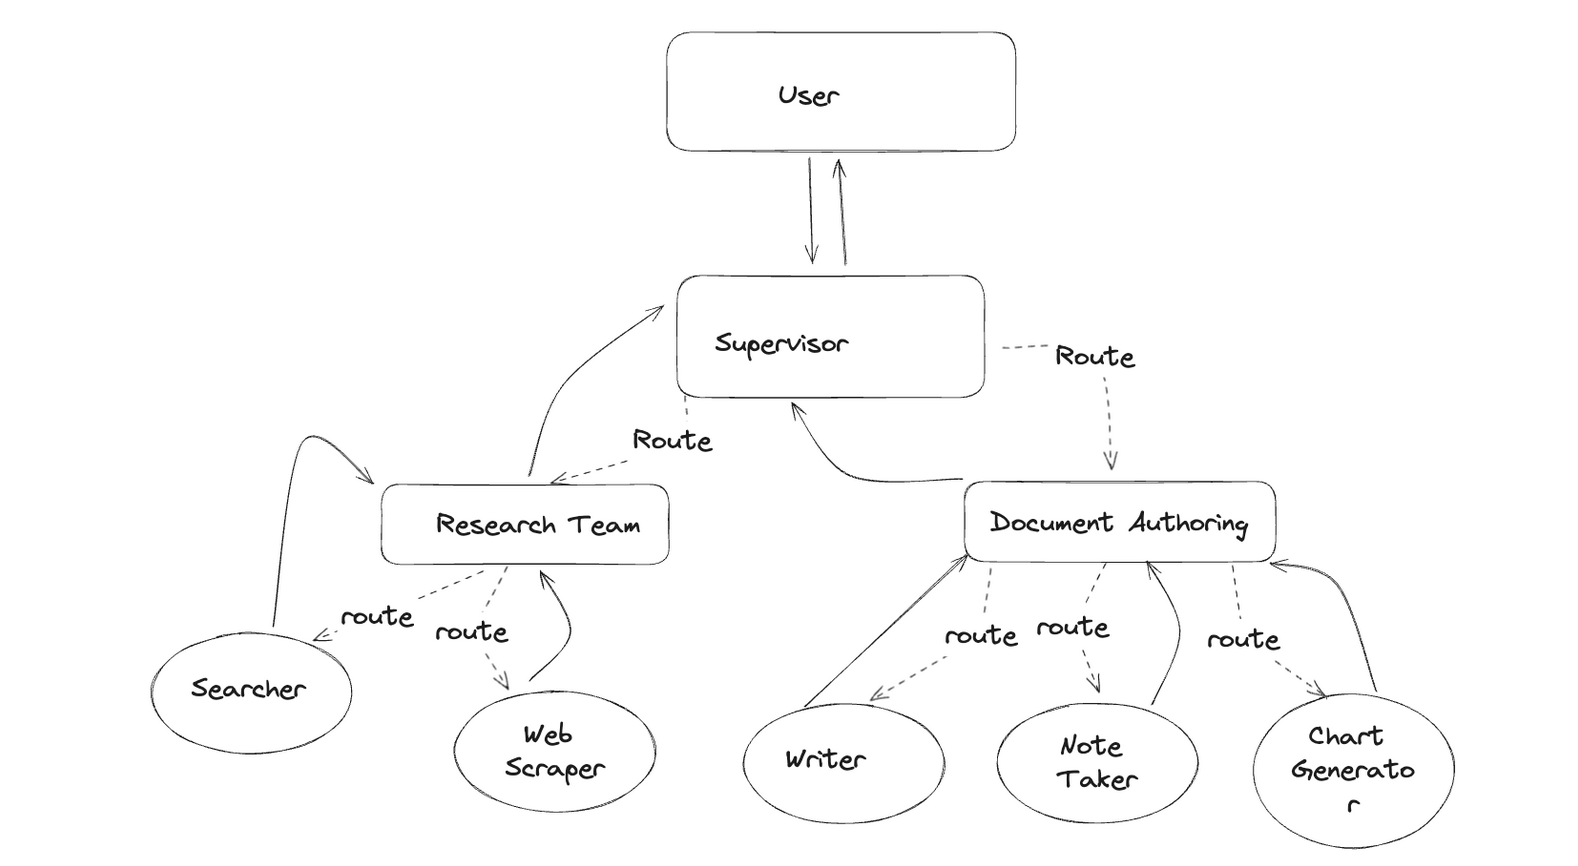

In [ ]:
pip install --upgrade --quiet langgraph langchain_community langchain_experimental langchain_openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.1/571.1 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 37.2 MB/s eta 0:00:00


Tavily를 사용하기 위해서는 api key를 발급 받아야합니다.

무료로 사용하실 경우 1000회까지 호출 가능합니다.
- api key 발급 받는 곳 : https://app.tavily.com/

In [ ]:
import getpass
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

### ResearchTeam tools

The research team can use a search engine and url scraper to find information on the web. Feel free to add additional functionality below to boost the team performance!

In [ ]:
from typing import Annotated, List

from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

tavily_tool = TavilySearchResults(max_results=5)


@tool
def scrape_webpages(urls: List[str]) -> str:
    """Use requests and bs4 to scrape the provided web pages for detailed information."""
    loader = WebBaseLoader(urls)
    docs = loader.load()
    return "\n\n".join(
        [
            f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

### Document writing team tools

In [ ]:
from pathlib import Path
from tempfile import TemporaryDirectory
from typing import Dict, Optional

from langchain_experimental.utilities import PythonREPL
from typing_extensions import TypedDict

# _TEMP_DIRECTORY = TemporaryDirectory()
WORKING_DIRECTORY = Path(Path("/content"))


@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to read the document from."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    return f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"

### Helper Utilities
We are going to create a few utility functions to make it more concise when we want to:

    - Create a worker agent.
    - Create a supervisor for the sub-graph.

These will simplify the graph compositional code at the end for us so it's easier to see what's going on.

In [ ]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


class State(MessagesState):
    next: str


def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
    options = ["FINISH"] + members
    system_prompt = (
        "You are a supervisor tasked with managing a conversation between the"
        f" following workers: {members}. Given the following user request,"
        " respond with the worker to act next. Each worker will perform a"
        " task and respond with their results and status. When finished,"
        " respond with FINISH."
    )

    class Router(TypedDict):
        """Worker to route to next. If no workers needed, route to FINISH."""

        next: Literal[*options]

    def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based router."""
        messages = [
            {"role": "system", "content": system_prompt},
        ] + state["messages"]
        response = llm.with_structured_output(Router).invoke(messages)
        goto = response["next"]
        if goto == "FINISH":
            goto = END

        return Command(goto=goto, update={"next": goto})

    return supervisor_node

### Research Team

In [ ]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o")

search_agent = create_react_agent(llm, tools=[tavily_tool])


def search_node(state: State) -> Command[Literal["supervisor"]]:
    result = search_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="search")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


web_scraper_agent = create_react_agent(llm, tools=[scrape_webpages])


def web_scraper_node(state: State) -> Command[Literal["supervisor"]]:
    result = web_scraper_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="web_scraper")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


research_supervisor_node = make_supervisor_node(llm, ["search", "web_scraper"])

In [ ]:
research_builder = StateGraph(State)
research_builder.add_node("supervisor", research_supervisor_node)
research_builder.add_node("search", search_node)
research_builder.add_node("web_scraper", web_scraper_node)

research_builder.add_edge(START, "supervisor")
research_graph = research_builder.compile()

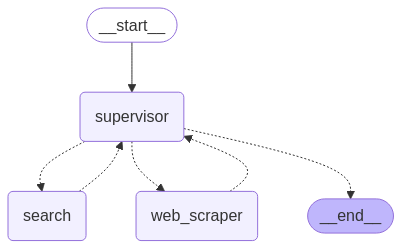

In [ ]:
from IPython.display import Image, display

display(Image(research_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in research_graph.stream(
    {"messages": [("user", "when is Taylor Swift's next tour?")]},
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'search'}}
---
{'search': {'messages': [HumanMessage(content="Taylor Swift's Eras Tour will continue into 2024 with dates announced for both the United States and Canada. The tour will resume in the U.S. on October 18, 2024, in Miami, Florida, and will include several major cities:\n\n- October 18-20, 2024: Miami, FL at the Hard Rock Stadium\n- October 25-27, 2024: New Orleans, LA at the Caesars Superdome\n- November 1-3, 2024: Indianapolis, IN at the Lucas Oil Stadium\n\nFollowing her U.S. dates, the tour will proceed to Canada with performances in Toronto at Rogers Centre from November 14-23, 2024, and in Vancouver at BC Place from December 6-8, 2024. \n\nFor more details, you can check out the article on [Sporting News](https://www.sportingnews.com/us/nfl/news/taylor-swift-tour-2024-tickets-prices-us-schedule-dates/612e97acae959d6de55ea896) or [Wikipedia](https://en.wikipedia.org/wiki/The_Eras_Tour).", additional_kwargs={}, response_metadata={}, name='search'

### Document Writing Team

In [ ]:
llm = ChatOpenAI(model="gpt-4o")

doc_writer_agent = create_react_agent(
    llm,
    tools=[write_document, edit_document, read_document],
    prompt=(
        "You can read, write and edit documents based on note-taker's outlines. "
        "Don't ask follow-up questions."
    ),
)


def doc_writing_node(state: State) -> Command[Literal["supervisor"]]:
    result = doc_writer_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="doc_writer")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


note_taking_agent = create_react_agent(
    llm,
    tools=[create_outline, read_document],
    prompt=(
        "You can read documents and create outlines for the document writer. "
        "Don't ask follow-up questions."
    ),
)


def note_taking_node(state: State) -> Command[Literal["supervisor"]]:
    result = note_taking_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="note_taker")
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


chart_generating_agent = create_react_agent(
    llm, tools=[read_document, python_repl_tool]
)


def chart_generating_node(state: State) -> Command[Literal["supervisor"]]:
    result = chart_generating_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=result["messages"][-1].content, name="chart_generator"
                )
            ]
        },
        # We want our workers to ALWAYS "report back" to the supervisor when done
        goto="supervisor",
    )


doc_writing_supervisor_node = make_supervisor_node(
    llm, ["doc_writer", "note_taker", "chart_generator"]
)

In [ ]:
# Create the graph here
paper_writing_builder = StateGraph(State)
paper_writing_builder.add_node("supervisor", doc_writing_supervisor_node)
paper_writing_builder.add_node("doc_writer", doc_writing_node)
paper_writing_builder.add_node("note_taker", note_taking_node)
paper_writing_builder.add_node("chart_generator", chart_generating_node)

paper_writing_builder.add_edge(START, "supervisor")
paper_writing_graph = paper_writing_builder.compile()

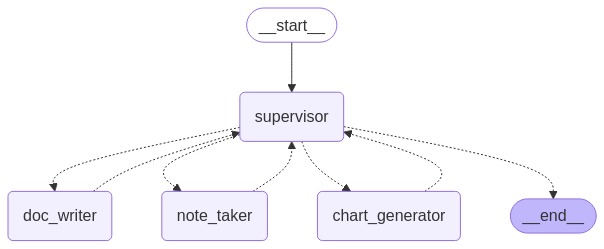

In [ ]:
from IPython.display import Image, display

display(Image(paper_writing_graph.get_graph().draw_mermaid_png()))

In [ ]:
for s in paper_writing_graph.stream(
    {
        "messages": [
            (
                "user",
                "Write an outline for poem about cats and then write the poem to disk.",
            )
        ]
    },
    {"recursion_limit": 100},
):
    print(s)
    print("---")

{'supervisor': {'next': 'note_taker'}}
---
{'note_taker': {'messages': [HumanMessage(content='The outline for the poem about cats has been created and saved as "poem_outline.txt".', additional_kwargs={}, response_metadata={}, name='note_taker', id='c0f66965-4846-4b21-91b3-b280ce0aadbb')]}}
---
{'supervisor': {'next': 'doc_writer'}}
---
{'doc_writer': {'messages': [HumanMessage(content='The poem about cats has been written and saved as "poem_about_cats.txt".', additional_kwargs={}, response_metadata={}, name='doc_writer', id='b7a38f7b-22c5-4948-8bb9-2032848e5727')]}}
---
{'supervisor': {'next': '__end__'}}
---


### Add Layers

In [ ]:
from langchain_core.messages import BaseMessage

llm = ChatOpenAI(model="gpt-4o")

teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [ ]:
def call_research_team(state: State) -> Command[Literal["supervisor"]]:
    response = research_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="research_team"
                )
            ]
        },
        goto="supervisor",
    )


def call_paper_writing_team(state: State) -> Command[Literal["supervisor"]]:
    response = paper_writing_graph.invoke({"messages": state["messages"][-1]})
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="writing_team"
                )
            ]
        },
        goto="supervisor",
    )


# Define the graph.
super_builder = StateGraph(State)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("research_team", call_research_team)
super_builder.add_node("writing_team", call_paper_writing_team)

super_builder.add_edge(START, "supervisor")
super_graph = super_builder.compile()

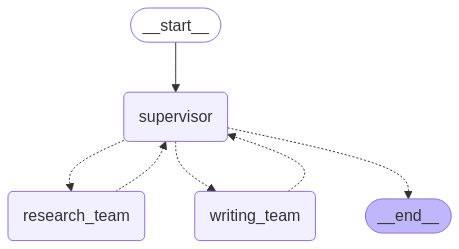

In [ ]:
from IPython.display import Image, display

display(Image(super_graph.get_graph().draw_mermaid_png()))

{'supervisor': {'next': 'research_team'}}
---
{'research_team': {'messages': [HumanMessage(content="AI agents are autonomous software entities designed to perform specific tasks with a high level of independence and intelligence. These agents leverage modern artificial intelligence technologies, such as machine learning models and natural language processing, to analyze data, make decisions, and execute actions efficiently. In 2023, AI agents have seen significant advancements and increasing applications across various fields. Here, we'll explore some key aspects and examples of AI agents based on recent developments:\n\n### Types and Examples of AI Agents in 2023:\n\n1. **Auto-GPT**: Developed by Toran Bruce Richards and released in March 2023, Auto-GPT is a prominent open-source AI agent. Its capabilities include analyzing tasks using GPT-4 models, breaking them down into manageable subtasks, and performing a range of activities such as social media management, text translation, and 

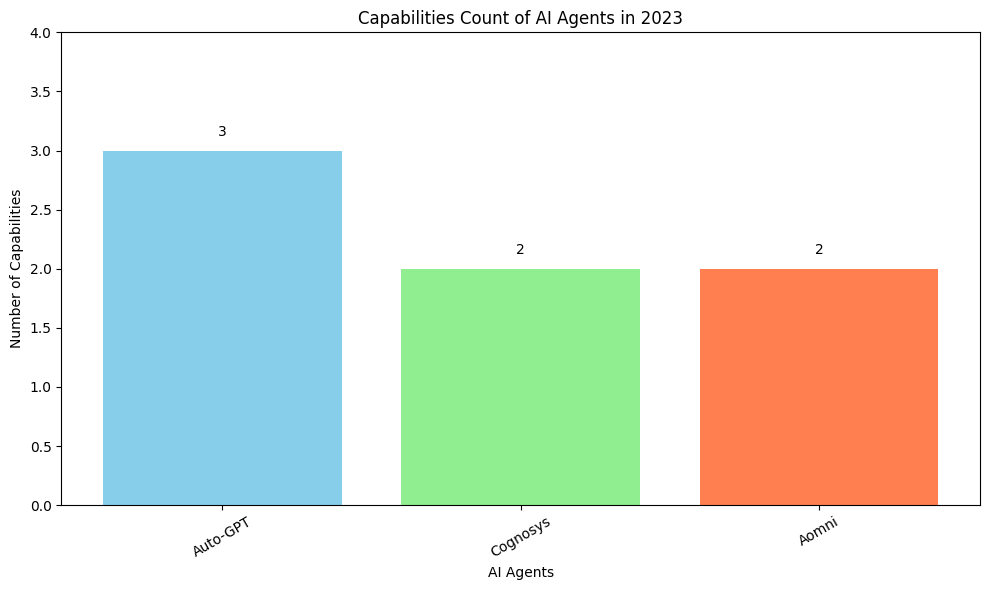

{'writing_team': {'messages': [HumanMessage(content='The bar chart comparing the capabilities of AI agents in 2023 has been generated successfully. Here it is:\n\n- **Auto-GPT** has 3 capabilities: Social Media Management, Text Translation, and Web Design.\n- **Cognosys** has 2 capabilities: Single-Step Task Execution and Multi-Step Workflow.\n- **Aomni** also has 2 capabilities: B2B Sales Automation and Real-Time Data Fetching.\n\nIf you need any further analysis or another chart, feel free to ask!', additional_kwargs={}, response_metadata={}, name='writing_team', id='67301ba7-07e2-4105-a213-cd2fe9c4f989')]}}
---
{'supervisor': {'next': '__end__'}}
---


In [ ]:
for s in super_graph.stream(
    {
        "messages": [
            ("user", "Research AI agents and write a brief report about them.")
        ],
    },
    {"recursion_limit": 150},
):
    print(s)
    print("---")

더 알아보기

https://langchain-ai.github.io/langgraph/tutorials/storm/storm/